<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios d'Informàtica, Multimèdia y Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRACTICA: Implementació d'un agent per a la robòtica espacial


## 1. Presentació

Al llarg de les tres parts de l'assignatura hem entrat en contacte amb diferents classes d'algoritmes d'aprenentatge per reforç que permeten resoldre problemes de control en una gran varietat d'entorns.

Aquesta pràctica, que s'estendrà al llarg d'un mes aproximadament, dóna la possibilitat d'enfrontar-se al disseny d'un agent per solucionar un cas específic de robotica.

Atacarem el problema a partir de l'exploració de l'entorn i les observacions. Després passarem a la selecció de l'algorisme més oportú per solucionar l'entorn en qüestió amb les observacions seleccionades. Finalment, passarem per l'entrenament i la prova de l'agent fins a arribar a l'anàlisi del rendiment.

Per fer-ho, es presentarà abans l'entorn de referència. Posteriorment, es passarà a la implementació d'un agent Deep Q-Network (DQN) que el solucioni. Després d'aquestes dues primeres fases de presa de contacte amb el problema, es cercarà un altre agent que pugui millorar el rendiment de l'agent DQN implementat anteriorment.

## 2. Competències
En aquesta activitat es treballen les següents competències:

● Capacitat per analitzar un problema des del punt de vista de l'aprenentatge per reforç.

● Capacitat per analitzar un problema en el nivell d'abstracció adequat a cada situació i aplicar les habilitats i coneixements adquirits per resoldre'ls.


## 3. Objectius
Els objectius concrets d'aquesta activitat són:

● Conèixer i aprofundir en el desenvolupament d'un entorn real que es pugui resoldre mitjançant tècniques d'aprenentatge per reforç.

● Aprendre a aplicar i comparar diferents mètodes d'aprenentatge per reforç per poder seleccionar el més adequat a un entorn i problemàtica concreta.

● Saber implementar els diferents mètodes, basats en solucions tabulars i solucions aproximades, per a resoldre un problema concret.

● Extreure conclusions a partir dels resultats obtinguts.

## 4. Entorn

Estem treballant sobre el problema de guia autònoma i en particular volem solucionar el cas de l’aterratge propi, per exemple, dels drons autònoms.

Per això, s'escull lunar-lander com a entorn simplificat. L'entorn es pot trobar al següent enllaç:
https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

Lunar Lander consisteix en una nau espacial que ha d'aterrar a un lloc determinat del camp d'observació. L'agent condueix la nau i el seu objectiu és aconseguir aterrar a la pista d'aterratge, coordenades (0,0), i arribar amb velocitat 0.

La nau consta de tres motors (esquerra, dreta i el principal que té a sota) que li permeten anar corregint el rumb fins a arribar a la destinació.

Les accions que pot fer la nau (espai d'accions) són discretes.

Les recompenses obtingudes al llarg del procés d'aterratge depenen de les accions que es prenen i del resultat que se'n deriva.

    ● Desplaçar-vos de dalt a baix, fins a la zona d'aterratge pot resultar en [+100,+140] punts

    ● Si s'estrella a terra, perd 100 punts (recompensa -100 punts)

    ● Si aconsegueix aterrar a la zona d'aterratge (velocitat 0), guanya +100 punts

    ● Si aterra, però no a la zona d'aterratge (fora de les banderes grogues) es perden punts

    ● El contacte d'una pota amb el terra rep +10 punts (si es perd contacte després d'aterrar, es perden punts)

    ● Cada cop que encén el motor principal perd 0.3 punts (recompensa -0.3 punts)

    ● Cada cop que encén un dels motors d'esquerra o dreta, perd 0,03 punts (recompensa -0.3 punts)

La solució òptima és aquella en què l'agent, amb un desplaçament eficient, aconsegueix aterrar a la zona d'aterratge (0,0), tocant amb les dues potes a terra i amb velocitat nul·la. Es considera que l'agent ha après a fer la tasca (i.e. el “joc” acaba) quan obté una mitjana d'almenys 200 punts durant 100 episodis consecutius.

In [1]:
import warnings
import time
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install gym[box2d]
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from copy import deepcopy
from datetime import datetime

In [2]:
# Comprovació de la versió de GYM instal·lada
print('La versió de gym instal·lada: ' + gym.__version__)

# Comprovació d'entorn amb gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("L'entorn utilitza: ", device)

La versió de gym instal·lada: 0.25.0
L'entorn utilitza:  cpu


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.1 (0.5 punts)</strong> Es demana explorar l’entorn i representar una execució aleatòria.
</div>


In [3]:
warnings.filterwarnings('ignore')
env = gym.make('LunarLander-v2')

print("- Rang de recompenses o llindar de les recompenses: {} ".format(env.reward_range))
print("- Màxim nombre de passos per episodi: {} ".format(env.spec.max_episode_steps)) 
print("- Espai d'accions: {} ".format(env.action_space.n))
print("- Espai d'estats continuu: {} ".format(env.continuous))
print("- Espai d'observacions: {} ".format(env.observation_space))


- Rang de recompenses o llindar de les recompenses: (-inf, inf) 
- Màxim nombre de passos per episodi: 1000 
- Espai d'accions: 4 
- Espai d'estats continuu: False 
- Espai d'observacions: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32) 


Hem pogut veure que el llindar de recompenses pot anar des de -infinit fins a +infinit. També que per cada episodi tenim un màxim de 1000 passos. Les accions són 4 que les comentarem en el següent exercici i aquestes són discretas (es pot configurar per a que siguin continues). L'espai d'observacions l'hem visualitzat i també el comentarem més endavant. Ara farem una execució aleatoria.

In [4]:
# inicialitzem l'entorn
obs = env.reset()
t, total_reward, done = 0, 0, False

# mostrem informació inicial
print("Obs: {}".format(obs))

while not done:
    
    # escollim la acció aleatoria
    action = env.action_space.sample()
    
    # executem la acció i obtenim el nou estat, la recompensa i si hem acabat    
    new_obs, reward, done, info = env.step(action)
    
    # mostrem informació
    print("\nObs: {} \nAcció: {} \nRecompensa: {} \nDone: {}".format(new_obs, action, reward, done))

    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1
    
print("Episodi finalitzat després de {} passos i recompensa de {} ".format(t, total_reward))
env.close()

Obs: [-0.00603857  1.4148172  -0.6116549   0.17318633  0.00700396  0.13854882
  0.          0.        ]

Obs: [-0.01216297  1.4181299  -0.6215329   0.14716157  0.01599806  0.179899
  0.          0.        ] 
Acció: 1 
Recompensa: -1.566284280442402 
Done: False

Obs: [-0.01835833  1.4208376  -0.6304292   0.1201912   0.02676686  0.21539624
  0.          0.        ] 
Acció: 1 
Recompensa: -1.6909863432875045 
Done: False

Obs: [-0.02465076  1.4229333  -0.6425952   0.09284838  0.03997317  0.2641508
  0.          0.        ] 
Acció: 1 
Recompensa: -2.3181057453865024 
Done: False

Obs: [-0.030865    1.4244294  -0.63276756  0.0661555   0.05119982  0.22455399
  0.          0.        ] 
Acció: 3 
Recompensa: -0.009161337801031094 
Done: False

Obs: [-0.03713932  1.425321   -0.64029646  0.03913998  0.06393396  0.25470614
  0.          0.        ] 
Acció: 1 
Recompensa: -1.9350422673543892 
Done: False

Obs: [-0.04348326  1.4256176  -0.64898574  0.01249104  0.0783955   0.28925753
  0.          

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.2 (0.5 punts)</strong>
Explicar els espais d'observacions i d'accions possibles (informe escrit).    
</div>

- Espai d'accions: com hem vist en l'exercici anterior l'espai d'accions és de 4. Hem definit un espai discret (podria ser continu). Les accions són les següents: 
    - Nop (no fer res)
    - Fire left engine (motor esquerra)
    - Main engine (motor principal)
    - Right engine (motor dret)
    

- Espai d'observacions: l'espai d'observacions està formada per un vector amb 8 coordenades.
    - la coordenada de x
    - la coordenada de y
    - la velocitat linear de x
    - la velocitat linear de y
    - l'angle
    - la velocitat angular
    - dos boolean que diuen si cada una de les potes està en contacte amb el terra

Anem a executar 1000 prenent accions de forma aleatòria. Emmagatzerem tant la suma de recompenses de cada partida com la quantitat d'episodis executats.

In [5]:
def play_games(num_games):    
    steps_list = []
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        total_reward, steps, done = 0, 0, False
        env.reset()
        while not done:         
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            if done:    
                steps_list.append(steps)
                total_reward_list.append(total_reward)
    return steps_list, total_reward_list      
          
steps_list, total_reward_list = play_games(1000)
env.close()   

Episode 999/1000.

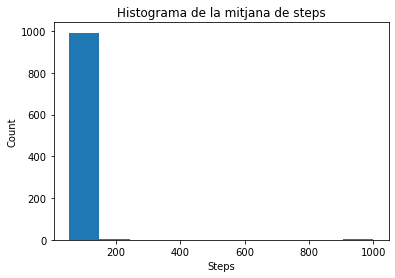

In [6]:
plt.hist(steps_list)
plt.title('Histograma de la mitjana de steps')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.show()

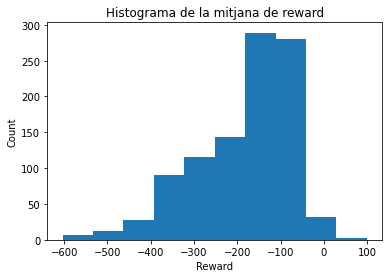

In [7]:
plt.hist(total_reward_list)
plt.title('Histograma de la mitjana de reward')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

In [8]:
print("La mitjana de les passes per episodi és de: {} ".format(np.mean(steps_list)))
print("La mitjana de les recompenses per episodi és de: {} ".format(np.mean(total_reward_list)))

La mitjana de les passes per episodi és de: 94.493 
La mitjana de les recompenses per episodi és de: -182.5141827272032 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
La mitjana de passes és del voltant de mes de 90 i la recomenpensa mitjana dels episodis és força negatiu. Fent servir algoritmes Deep Q-Networks hauriem d'aconseguir millorar aquests valors de recompensa ja que hem triat accions totalment aleatories. 
</div>

## 5. Agent de referència

A la tercera part de l'assignatura hem introduït l'agent DQN amb replay buffer i target network, que és un bon candidat per a la solució del problema de robòtica que estem analitzant, donat que permet controlar entorns amb un nombre elevat d'estats i accions de forma eficient.

Es demana resoldre els 3 exercicis següents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.1 (1.5 punts):</strong> Implementar un agent DQN per a l'entorn lunar-lander.
</div>

Per entrenar una xarxa neuronal per resoldre el problema de "LunarLander-v2" fem servir una arquitectura amb una capa d'entrada amb 8 canals d'entrada (per cada un dels atributs de les observacions), una capa intermitja amb 32 entrades i 64 sortides i finalment una capa de sortida amb les 64 entrades i 4 sortides (una per cada una de les possibles accions). Fem servir tant l'algorisme d'optimització Adam com mètode e-greedy per a que anem alternant accions aleatories amb accions de l'aprenentatge. Al principi totes són aleatories i posteriorment de forma incremental anem afegint del model.

In [9]:
class DQN_CNN(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super(DQN_CNN, self).__init__()
        """
        Params
        ======
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'acciones possibles
        device: cpu o cuda
        red_cnn: definició de la xarxa convolucional
        red_lineal: definició de la xarxa lineal
        """
        #######################################
        ### Inicialització i model ###        

        # learning rate de l'optimitzador        
        self.learning_rate = learning_rate
        # Inicialització de l'espai d'estats a 8 i d'accions a 4        
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        #######################################
        # ## Construcció de la xarxa neuronal      
        self.red_lineal = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.n_outputs),
            nn.ReLU()
        )

        if torch.cuda.is_available():
            self.red_lineal.cuda()

        #######################################
        ## Inicialitzar l'optimitzador
        ## Recupera els paràmetres de la xarxa neuronal i inicialitza l'optimitzador amb el learning rate indicat en el constructor      
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    ### Mètode e-greedy per a l'acció a realitzar en un estat determinat
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:           
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action

    ### Mètode per a calcular els qvals d'un estat determinat     
    def get_qvals(self, state):        
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.red_lineal(state_t)

    
    def feature_size(self):
        return self.red_cnn(autograd.Variable(torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)

In [10]:
class DQNAgent:
    ###################################################
    ###### Declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100):
        """"
        Params
        ======
        env: entorn
        main_network: classe amb la xarxa neuronal dissenyada
        target_network: xarxa objectiu
        buffer: classe amb el buffer de repetició d'experiències
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloc dels X darrers episodis dels quals es calcularà la mitjana de recompensa
        reward_threshold: llindar de recompensa on es considera que s'ha assolit el problema
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # xarxa objectiu (còpia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock # són els blocs dels X episodis dels quals es calcularà la mitjana de recompensa
        self.reward_threshold = reward_threshold # llindar de recompensa, si es supera es para el procés d'entrenament
        self.initialize()

    ###################################################################
    ##### Inicialitzar variables extra que són necessàries per a l'entrenament
    def initialize(self):
        self.update_loss = []
        self.training_update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset() # reset de l'entorn i obtenció de l'estat inicial

    #################################################################################
    ###### Prendre una nova acció ############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acció aleatòria al burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acció a partir del valor de Q (elecció de l'acció amb millor Q)
            self.step_count += 1

        # Realització de l'acció i obtenció del nou estat i la recompensa.
        new_state, reward, done, _ = self.env.step(action) 
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiència al buffer
        self.state0 = new_state

        # Resetejar entorn 'if done'
        if done:
            self.state0 = self.env.reset()
        return done
    
    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000, dnn_update_frequency=4, dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Omplim el buffer amb N experiències aleatòries per a fer burn-in
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        start_time = datetime.now()
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')
                #################################################################################
                #### Actualitzar xarxa principal segons la freqüència establerta #########
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                
                ########################################################################################
                ### Sincronitzar xarxa principal i xarxa objectiu segons la freqüència establerta
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(self.main_network.state_dict())                                        
                                       
                if gamedone:
                    episode += 1                    
                    ##################################################################
                    ######## Emmagatzemar epsilon, training rewards i loss#######
                    self.save_statistics()

                    #######################################################################################
                    ### Calcular la mitjana de recompensa dels últims X episodis, i emmagatzemar####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.calculate_mean_rewards(mean_rewards)

                    ##################################################################
                    ### calcular el temps restant i mostrar-lo
                    self.calculate_remaining_time(start_time, episode, max_episodes, mean_rewards)
              
                    #################################################################################
                    ### comprovar si s'ha assolit el màxim d'episodis
                    training = not self.is_solved_by_episode(episode, max_episodes)

                    #################################################################################
                    ### si no s'ha assolit el màxim d'episodis, continuar entrenant
                    if not training:
                        print('\nTraining finished.')
                        break

                    #################################################################################
                    ### comprovar si s'ha assolit el llindar de recompensa i un mínim d'episodis
                    training = not self.is_solved_by_reward(episode, min_episodios, mean_rewards)

                    #################################################################################
                    ### si no s'ha assolit el màxim d'episodis, continuar entrenant
                    if not training:
                        print('\nTraining finished.')
                        break
                    
                    #################################################################################
                    ###### Actualitzar epsilon ########
                    # actualitzar epsilon segons la velocitat de descens fixada on no pot ser inferior a min_epsilon
                    self.epsilon = max(self.epsilon * self.eps_decay, min_epsilon)


    ##################################################################
    ######## Comprovar si s'ha arribat al llindar de recompensa i un mínim d'episodis
    def is_solved_by_reward(self, episode, min_episodios, mean_rewards):  
        if mean_rewards >= self.reward_threshold and min_episodios <  episode:
            print('\nEnvironment solved in {} episodes!'.format(episode))
            return True
        else:
            return False

    ##################################################################
    ######## Comprovar si s'ha arribat al màxim d'episodis
    def is_solved_by_episode(self, episode, max_episodes):
        if episode >= max_episodes:
            print('\nEpisode limit reached.')
            return True
        else:
            return False

    ###############################################################
    ######## Calcular el temps restant i mostrar-lo
    def calculate_remaining_time(self, start_time, episode, max_episodes, mean_rewards):
        end_time = datetime.now()
        # get difference time
        delta = end_time - start_time 
        # time difference in minutes
        total_minutes = delta.total_seconds() / 60
        estimated_remain_time = total_minutes / episode * (max_episodes - episode)                    
        print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} Time {} minutes Remaining Time {} minutes\t\t"
              .format(episode, mean_rewards, round(self.epsilon,4),round(total_minutes,2), round(estimated_remain_time,2)), end="")               
        

    ##################################################################
    ######## Calcular la mitjana de recompensa dels últims X episodis, i emmagatzemar####
    def calculate_mean_rewards(self, mean_rewards):
        self.mean_training_rewards.append(mean_rewards)

    ##################################################################
    ######## Emmagatzemar epsilon, training rewards i loss#######
    def save_statistics(self):
        self.sync_eps.append(self.epsilon)
        self.training_rewards.append(self.total_reward)         
        self.training_update_loss.append(np.mean(self.update_loss))                                              
        self.update_loss = []

    ####################################
    #### Càlcul de la pèrdua ####
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenim els valors de Q de la xarxa objectiu
        # El paràmetre detach() evita que aquests valors actualitzin la xarxa objectiu
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estats terminals

        #################################################################################
        ### Calcular l'equació de Bellman
        expected_qvals = rewards_vals + self.gamma * qvals_next
        
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch)# calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.main_network.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Guardem els valors de pèrdua
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

In [11]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, replace=False)
        # Ús de l'operador asterisc per desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [12]:
def plot_rewards(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.training_rewards, label='Rewards')
        plt.plot(agent.mean_training_rewards, label='Mean Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

def plot_loss(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.training_update_loss, label='Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        plt.show()
        
def plot_epsilon(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.sync_eps, label='Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.legend(loc="upper left")
        plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.2 (1 punt):</strong> Entreneu l'agent DQN i busqueu els valors dels hiperparàmetres que obtinguin un alt rendiment de l'agent. Per fer-ho, cal llistar els hiperparàmetres sota estudi i presentar les gràfiques de les mètriques que descriuen l'aprenentatge.
</div>

Filling replay buffer...
Training...
Episode 2000 Mean Rewards -137.21 Epsilon 0.01 Time 12.28 minutes Remaining Time 0.0 minutes				
Episode limit reached.

Training finished.


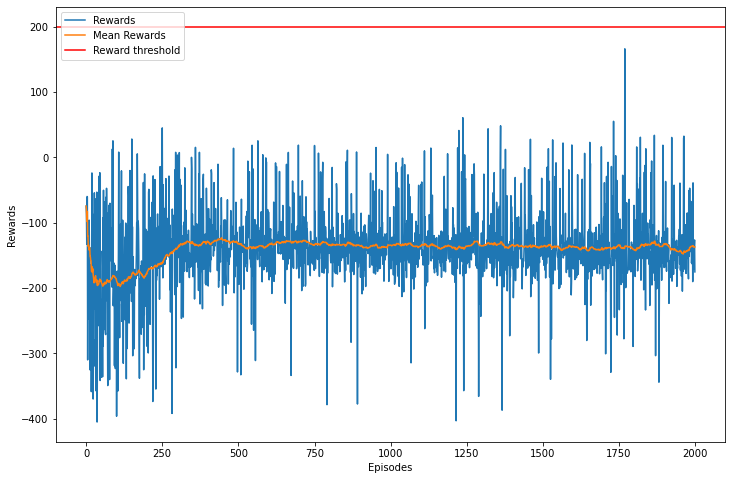

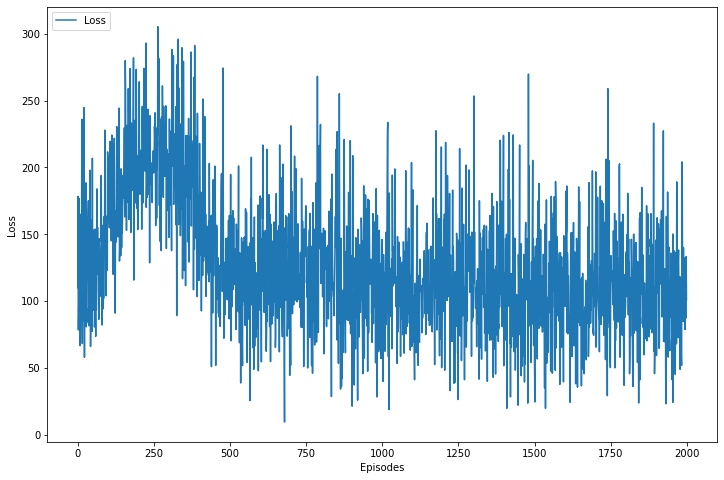

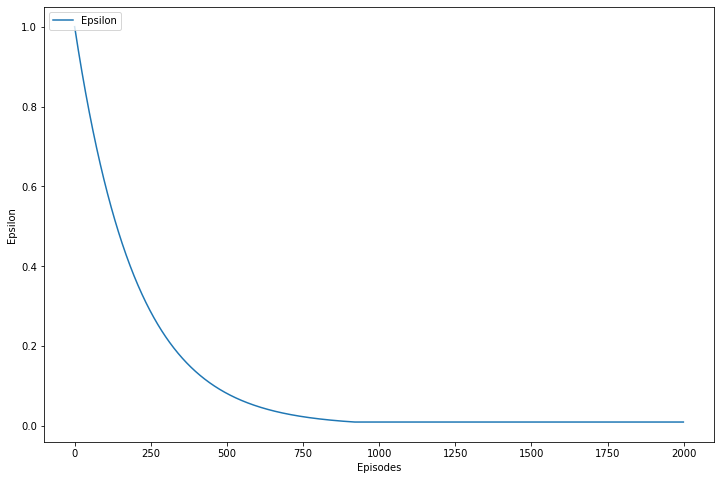

In [23]:
env = gym.make('LunarLander-v2')

lr = 0.0005             # (0.001) Velocitat d'aprenentatge
BATCH_SIZE = 8          #Conjunt a agafar del buffer per a la xarxa neuronal
MEMORY_SIZE = 50000     #Màxima capacitat del buffer
GAMMA = 0.99            #Valor gamma de l'equació de Bellman
EPSILON = 1             #Valor inicial d'epsilon
EPSILON_DECAY = 0.995   #Decaïment d'epsilon
EPSILON_MIN = 0.01      #Valor mínim d'epsilon
BURN_IN = 10000         #Nombre d'episodis inicials utilitzats per emplenar el buffer abans d'entrenar
MAX_EPISODES = 2000     #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250      #Nombre mínim d'episodis
DNN_UPD = 1             #Freqüència d'actualització de la xarxa neuronal
DNN_SYNC = 1000         #Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

REWARD_THRESHOLD = 200 #Llindar de recompensa on es considera que s'ha assolit el problema

buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
dqn = DQN_CNN(env, learning_rate=lr)
agentDQN = DQNAgent(env, dqn, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)
agentDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

plot_rewards(agentDQN)
plot_loss(agentDQN)
plot_epsilon(agentDQN)        

env.close()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.3 (0.5 punts):</strong> Visualitzar-ne el comportament (a través de
gràfiques de les mètriques més oportunes).
</div>

Episode 49/50.

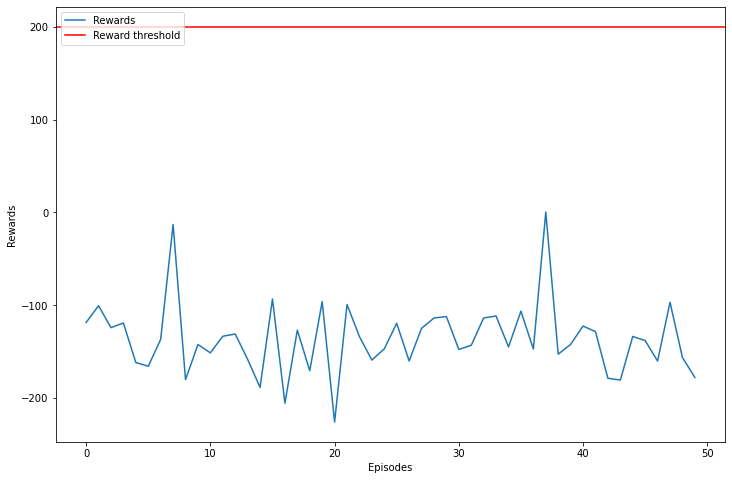

In [14]:
env = gym.make('LunarLander-v2')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            action = ag.main_network.get_action(state,epsilon=0.0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          



def plot_rewards_min(agent, total_reward_list):
        plt.figure(figsize=(12,8))
        plt.plot(total_reward_list, label='Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

total_reward_list = play_games(env, agentDQN, 50)
plot_rewards_min(agentDQN, total_reward_list)

El principal problema que té aquest model és que no sempre convergeix. És inestable i en moltes ocasions és queda en valors de Q on no aconseguim millorar les puntuacions.

## 6. Proposta de millora

En aquesta part es demana proposar una solució alternativa al problema de robòtica espacial que pugui ser més eficient respecte a allò que s'ha implementat anteriorment. 
Per assolir aquest objectiu, cal implementar un nou agent, basat en els algoritmes que hem vist al llarg de l’assignatura.

Es demana resoldre els 3 exercicis següents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.1 (2 punts):</strong> Implementar l'agent identificat a l'entorn lunar-lander.
    
Justifiqueu les raons que han portat a provar aquest tipus d'observació entre les disponibles i perquè s'ha triat aquest tipus d'agent. Detalleu quins tipus de problemes s'espera que es puguin solucionar respecte a la implementació anterior
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.2 (2 punts):</strong> Entrenar l'agent identificat i cercar els valors dels hiperparàmetres que obtinguin el
rendiment 'òptim' de l'agent.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.3 (2 punts):</strong> Analitzar el comportament de l'agent entrenat a l'entorn de prova i comparar-lo amb
l'agent implementat en el punt 2 (a través de gràfiques de les mètriques més oportunes).
</div>